### 📚 Könyvkategorizáló NLP Projekt

**Cél:** Gépi tanulási modell fejlesztése, amely **leírás és oldalszám alapján** automatikusan eldönti, hogy egy könyv **gyerekeknek vagy felnőtteknek** szól-e.

**A folyamat fő lépései:**
* Goodreads adatok letöltése, címkék alapján szűrése és tisztítása.
* **NLP & Feature Engineering:** Szövegelemzés, felesleges szavak törlése és TF-IDF vektorizáció.
* **Modellezés:** Három algoritmus (Logisztikus Regresszió, Döntési Fa, Neurális Háló) összehasonlítása a legpontosabb találatért.
* **Deployment:** Egy interaktív Gradio webes felület, ahol a felhasználók valós időben tesztelhetik a végső modellt szabadon választott rövid könyvismertető szövegekre.

In [1]:
import gzip
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import unittest
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from scipy.sparse import hstack
import gradio as gr

# NLTK adatok letöltése
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# FORRÁS: https://cseweb.ucsd.edu/~jmcauley/datasets/goodreads.html
# URL-ek definiálása
URLS = {
    "child": ["https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_books_children.json.gz"],
    "adult": [
        "https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_books_history_biography.json.gz",
        "https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_books_mystery_thriller_crime.json.gz",
        "https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_books_romance.json.gz",
        "https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_books_fantasy_paranormal.json.gz"
    ]
}

# Globális változók
all_books_data = []
seen_book_ids = set() # duplikáció szűréshez

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# ------ KATEGÓRIA SZŰRŐ ------

def is_child_book(shelves):
    """Ellenőrzi: van 'children' 'polc' ÉS 10-nél többen jelölték?"""
    if not shelves: return False
    for shelf in shelves:
        name = shelf.get('name', '').lower()
        count = int(shelf.get('count', 0))
        if 'children' in name and count > 10:
            return True
    return False

def is_adult_book(shelves):
    """Ellenőrzi: mentes minden gyerekre utaló címkétől?"""
    if not shelves: return True
    forbidden = ['children', 'young-adult']
    for shelf in shelves:
        name = shelf.get('name', '').lower()
        for tag in forbidden:
            if tag in name:
                return False # ha van gyerek címke, kizárjuk
    return True

# ------ SPEC. LETÖLTŐ FV. ------

def process_url(url, target_label, limit=None):
    """URL letöltése, szűrése és hozzáadása a közös listához."""
    print(f"Feldolgozás: {target_label} -> {url.split('/')[-1]}...")
    local_count = 0

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with gzip.open(r.raw, mode='rt', encoding='utf-8') as f:
            for line in f:
                if limit and local_count >= limit: break

                try:
                    book = json.loads(line)
                    bid = book.get('book_id')

                    if bid in seen_book_ids: continue

                    shelves = book.get("popular_shelves")
                    match = False
                    if target_label == 'gyerek': match = is_child_book(shelves)
                    else: match = is_adult_book(shelves)

                    if match:
                        clean_data = {
                            'title': book.get('title_without_series'),
                            'description': book.get('description'),
                            'pages': book.get('num_pages'),
                            'label': target_label
                        }
                        all_books_data.append(clean_data)
                        seen_book_ids.add(bid)
                        local_count += 1

                except (json.JSONDecodeError, ValueError):
                    continue
    print(f"   -> Kész. Hozzáadva: {local_count} db.")

In [3]:
# Gyerek könyvek gyűjtése
for url in URLS['child']:
    process_url(url, target_label='gyerek', limit=None)

# Felnőtt könyvek gyűjtése
for url in URLS['adult']:
    process_url(url, target_label='felnőtt', limit=10000)

print(f"\nÖSSZESÍTÉS: {len(all_books_data)} db könyv sikeresen összegyűjtve.")

Feldolgozás: gyerek -> goodreads_books_children.json.gz...
   -> Kész. Hozzáadva: 36500 db.
Feldolgozás: felnőtt -> goodreads_books_history_biography.json.gz...
   -> Kész. Hozzáadva: 10000 db.
Feldolgozás: felnőtt -> goodreads_books_mystery_thriller_crime.json.gz...
   -> Kész. Hozzáadva: 10000 db.
Feldolgozás: felnőtt -> goodreads_books_romance.json.gz...
   -> Kész. Hozzáadva: 10000 db.
Feldolgozás: felnőtt -> goodreads_books_fantasy_paranormal.json.gz...
   -> Kész. Hozzáadva: 10000 db.

ÖSSZESÍTÉS: 76500 db könyv sikeresen összegyűjtve.


In [4]:
# ------ SZÖVEGTISZTÍTÓ ------

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # kisbetűsítés
    text = text.lower()

    # HTML tagek eltávolítása
    text = re.sub(r'<.*?>', '', text)

    # nem betű karakterek (számok, írásjelek) cseréje szóközre
    text = re.sub(r'[^a-z\s]', ' ', text)

    # felesleges szóközök eltüntetése
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [5]:
class TestProjectLogic(unittest.TestCase):

    # ------ SZŰRŐK TESZTELÉSE ------
    def test_is_child_book(self):
        self.assertTrue(is_child_book([{'name': 'children-books', 'count': 50}]))

        # Hiba (count <= 10)
        self.assertFalse(is_child_book([{'name': 'children', 'count': 5}]))

    def test_is_adult_book(self):
        # Kizáró ok: young-adult
        self.assertFalse(is_adult_book([{'name': 'history', 'count': 100}, {'name': 'young-adult', 'count': 5}]))

        self.assertTrue(is_adult_book([{'name': 'crime', 'count': 20}]))

    # ------ TISZTÍTÓ FÜGGVÉNY TESZTELÉSE ------
    def test_preprocess_text_html(self):
        raw = "<div>Hello <b>World</b></div>"
        expected = "hello world"
        self.assertEqual(preprocess_text(raw), expected)

    def test_preprocess_text_special_chars(self):
        raw = "Book #1: The Best of 2025!"
        expected = "book the best of"
        self.assertEqual(preprocess_text(raw), expected)

    def test_preprocess_text_empty(self):
        self.assertEqual(preprocess_text(None), "")
        self.assertEqual(preprocess_text(123), "")

print("------ UNIT TESZTEK ------")
unittest.main(argv=[''], verbosity=2, exit=False)

test_is_adult_book (__main__.TestProjectLogic.test_is_adult_book) ... ok
test_is_child_book (__main__.TestProjectLogic.test_is_child_book) ... ok
test_preprocess_text_empty (__main__.TestProjectLogic.test_preprocess_text_empty) ... ok
test_preprocess_text_html (__main__.TestProjectLogic.test_preprocess_text_html) ... ok
test_preprocess_text_special_chars (__main__.TestProjectLogic.test_preprocess_text_special_chars) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.011s

OK


------ UNIT TESZTEK ------


In [6]:
df = pd.DataFrame(all_books_data)
df_clean = df.copy()

print(f"Eredeti méret: {len(df_clean)} sor")

# üres stringek NaN-ra
df_clean.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# oldalszám konvertálása
df_clean['pages'] = pd.to_numeric(df_clean['pages'], errors='coerce')

# nincs cím vagy leírás, eldobjuk
df_clean = df_clean.dropna(subset=['title', 'description'])

# nincs oldalszám, pótoljuk a mediánnal
median_pages = df_clean['pages'].median()
df_clean['pages'] = df_clean['pages'].fillna(median_pages).astype(int)

# túl rövid leírások törlése
df_clean = df_clean[df_clean['description'].str.len() > 20]

# (Gyerek=1, Felnőtt=0)
label_map = {'felnőtt': 0, 'gyerek': 1}
df_clean['label_numeric'] = df_clean['label'].map(label_map)

print(f"Tisztított méret: {len(df_clean)} sor (Eldobva: {len(df) - len(df_clean)})")
display(df_clean.head())

Eredeti méret: 76500 sor
Tisztított méret: 69556 sor (Eldobva: 6944)


,title,description,pages,label,label_numeric
0,Dog Heaven,In Newbery Medalist Cynthia Rylant's classic b...,40,gyerek,1
1,The tale of Jemima puddle-duck,"Searching for a convenient nesting place, befu...",208,gyerek,1
2,"Alice's adventures in Wonderland ; and, Throug...",By falling down a rabbit hole and stepping thr...,208,gyerek,1
3,The Saturdays,Meet the Melendys! The four Melendy children l...,192,gyerek,1
4,Revenge Of The Living Dummy (Goosebumps Horror...,Britney Crosby encounters an old ventriloquist...,128,gyerek,1


In [7]:
# ------ SZÖVEGTISZTÍTÁS ALKALMAZÁSA ------

print("Szövegtisztítás folyamatban...")

df_clean['clean_text'] = df_clean['description'].apply(preprocess_text)

df_clean = df_clean[df_clean['clean_text'] != ""]

pd.set_option('display.max_colwidth', 50)
display(df_clean[['description', 'clean_text']].head(5))

Szövegtisztítás folyamatban...


,description,clean_text
0,In Newbery Medalist Cynthia Rylant's classic b...,in newbery medalist cynthia rylant s classic b...
1,"Searching for a convenient nesting place, befu...",searching for a convenient nesting place befud...
2,By falling down a rabbit hole and stepping thr...,by falling down a rabbit hole and stepping thr...
3,Meet the Melendys! The four Melendy children l...,meet the melendys the four melendy children li...
4,Britney Crosby encounters an old ventriloquist...,britney crosby encounters an old ventriloquist...


In [8]:
# ------ VIZUALIZÁCIÓS ADATOK ELŐKÉSZÍTÉSE ------

print("Folyamatban...")

# Alap NLTK STOPWORDS
stop_words = set(nltk.corpus.stopwords.words('english'))

# SAJÁT szűrőlista
custom_stops = {'book', 'story', 'read', 'one', 'life', 'new', 'time', 'world',
                'series', 'first', 'author', 'novel', 'characters', 'love'}
stop_words.update(custom_stops)

# LEAKAGE szavak
leakage_words = {
    'children', 'childrens', 'kids', 'child', 'kid', 'young', 'adult',
    'adults', 'teens', 'teen', 'teenager', 'readers', 'reader',
    'year', 'years', 'old', 'age', 'ages', 'grade'
}
stop_words.update(leakage_words)

def get_filtered_words(text_series):
    all_words = []
    for text in text_series:
        words = text.split()
        filtered = [w for w in words if w not in stop_words and len(w) > 2]
        all_words.extend(filtered)
    return all_words

# Gyerek könyvek szavai
child_texts = df_clean[df_clean['label'] == 'gyerek']['clean_text']
child_words = get_filtered_words(child_texts)

# Felnőtt könyvek szavai
adult_texts = df_clean[df_clean['label'] == 'felnőtt']['clean_text']
if len(adult_texts) > 20000:
    adult_texts = adult_texts.sample(n=20000, random_state=42)

adult_words = get_filtered_words(adult_texts)

print(f"Feldolgozott szavak száma: Gyerek={len(child_words)}, Felnőtt={len(adult_words)}")

Folyamatban...
Feldolgozott szavak száma: Gyerek=1828083, Felnőtt=1694067


In [9]:
# --- WORDCLOUD ÉS TOP SZAVAK ---

def plot_wordcloud(words_list, title):
    if not words_list: return
    text = " ".join(words_list)
    wc = WordCloud(width=800, height=400, background_color='white',
                   max_words=100, colormap='viridis', collocations=False, random_state=42).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18, pad=20)
    plt.show()

def plot_top_words(words_list, title, color):
    if not words_list: return
    counter = Counter(words_list)
    most_common = counter.most_common(15)

    words = [x[0] for x in most_common]
    counts = [x[1] for x in most_common]

    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color=color)
    plt.xlabel('Előfordulás száma')
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()
    plt.show()





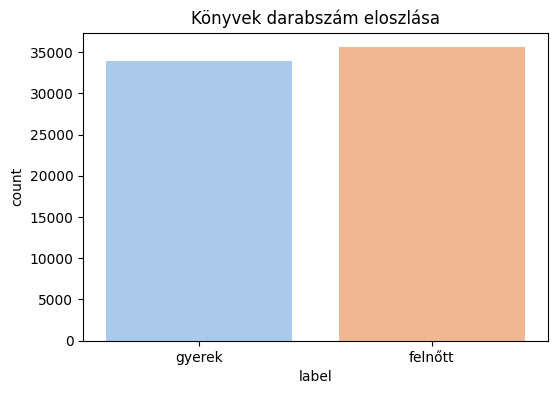

In [10]:
df_clean['desc_length'] = df_clean['description'].str.len()

plt.figure(figsize=(6, 4))
sns.countplot(data=df_clean, x='label', palette='pastel', hue='label', legend=False)
plt.title("Könyvek darabszám eloszlása")
plt.show()

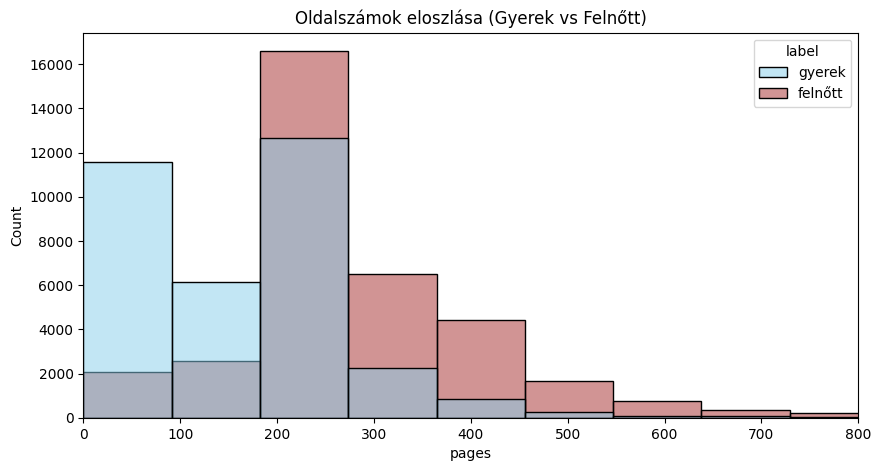


--- Medián értékek ---


,pages,desc_length
label,,
felnőtt,223.0,845.0
gyerek,176.0,504.0


In [11]:

plt.figure(figsize=(10, 5))
sns.histplot(data=df_clean, x='pages', hue='label', bins=50, palette={'gyerek': 'skyblue', 'felnőtt': 'brown'})
plt.xlim(0, 800)
plt.title("Oldalszámok eloszlása (Gyerek vs Felnőtt)")
plt.show()

print("\n--- Medián értékek ---")
stats = df_clean.groupby('label')[['pages', 'desc_length']].median()
display(stats)

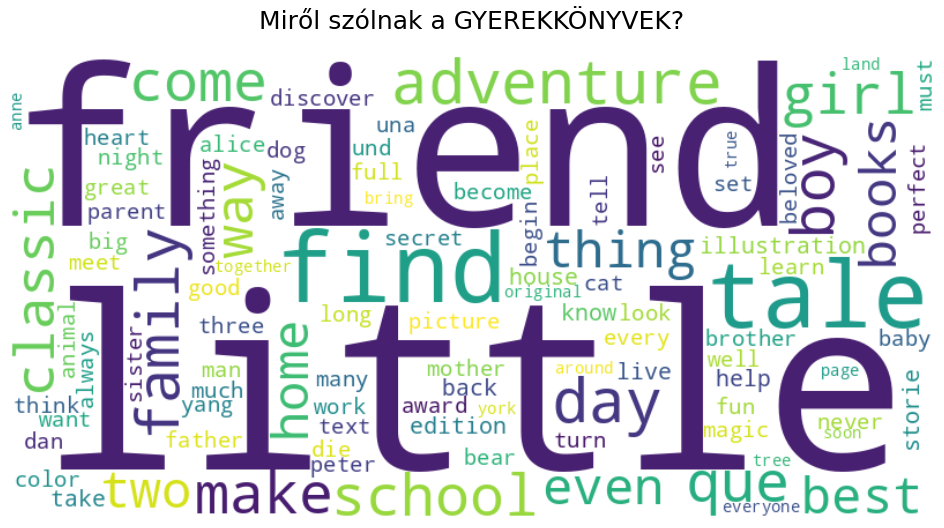

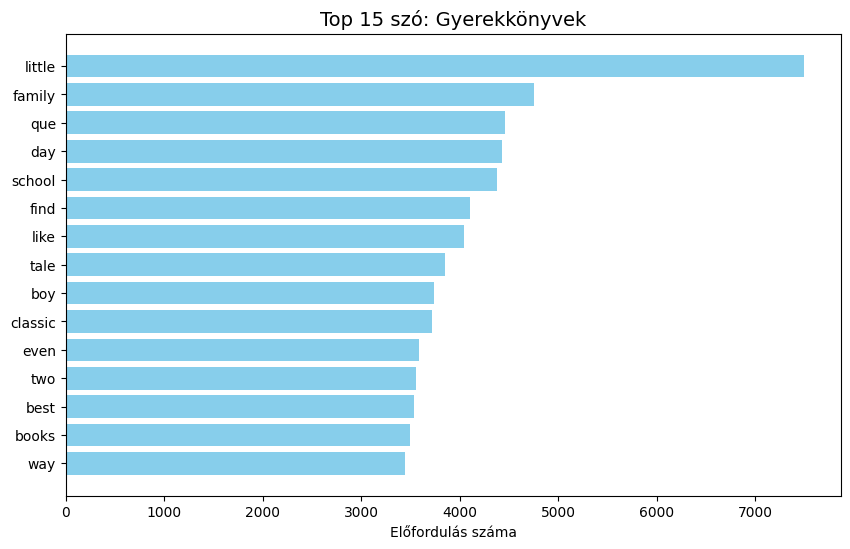

In [12]:
plot_wordcloud(child_words, "Miről szólnak a GYEREKKÖNYVEK?")
plot_top_words(child_words, "Top 15 szó: Gyerekkönyvek", 'skyblue')

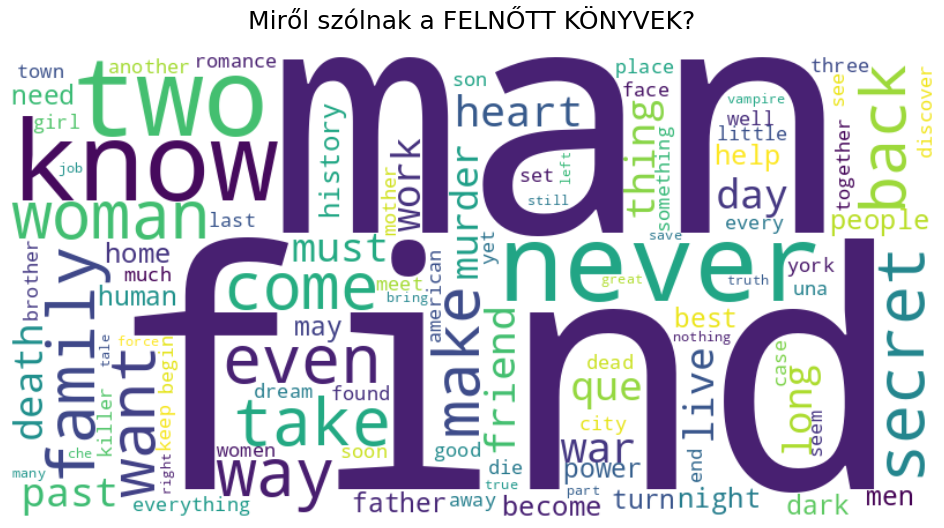

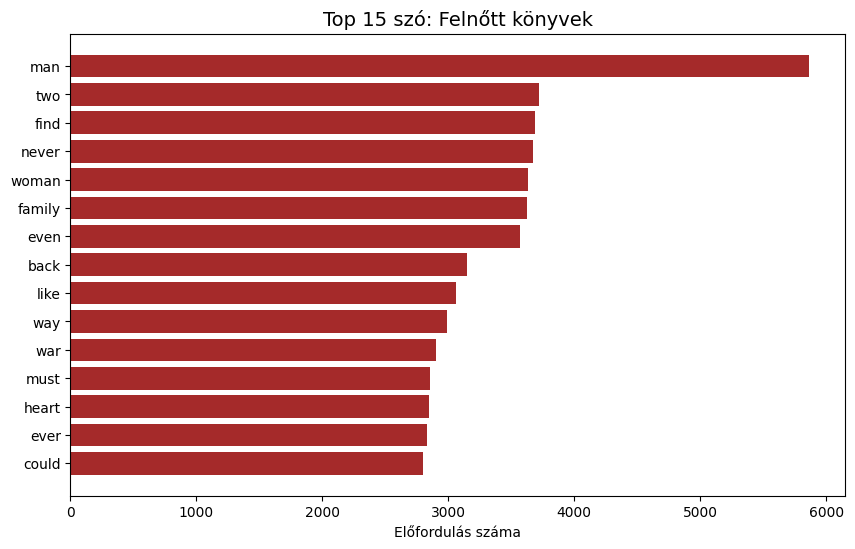

In [13]:
plot_wordcloud(adult_words, "Miről szólnak a FELNŐTT KÖNYVEK?")
plot_top_words(adult_words, "Top 15 szó: Felnőtt könyvek", 'brown')

In [14]:
# ------ FEATURE ENGINEERING ÉS ADATELŐKÉSZÍTÉS ------

# stopwords lista a modellhez
final_stop_words = set(nltk.corpus.stopwords.words('english'))
final_stop_words.update(custom_stops)
final_stop_words.update(leakage_words)

# X (Jellemzők) előállítása
# SZÖVEG: TF-IDF, csak az 5000 legfontosabb szóval
tfidf = TfidfVectorizer(max_features=5000, stop_words=list(final_stop_words))
X_text = tfidf.fit_transform(df_clean['clean_text'])

# OLDALSZÁM: Skálázás, mert az oldalszám sokkal nagyobb szám, mint a TF-IDF értékek
scaler = StandardScaler()
X_pages = scaler.fit_transform(df_clean[['pages']].values.astype(float))

# ÖSSZEFŰZÉS
X = hstack([X_text, X_pages])
y = df_clean['label_numeric']

print(f"Bemeneti mátrix mérete: {X.shape} (Sorok, Jellemzők)")

# adatok szétvágása (Train 70% / Validation / Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 15% validáció, 15% teszt
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTanító halmaz (Train): {X_train.shape[0]} db")
print(f"Validációs halmaz (Val): {X_val.shape[0]} db")
print(f"Teszt halmaz (Test):     {X_test.shape[0]} db")

Bemeneti mátrix mérete: (69554, 5001) (Sorok, Jellemzők)

Tanító halmaz (Train): 48687 db
Validációs halmaz (Val): 10433 db
Teszt halmaz (Test):     10434 db


In [15]:
# ------ MODELLEK TANÍTÁSA ------

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=20, random_state=42),
    "MLP Neural Net": MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, verbose=True, early_stopping=True, random_state=42)
}

best_score = 0
best_model_name = ""
best_model_obj = None

print("Modellek versenyeztetése...")
print("-" * 40)

for name, model in models.items():
    print(f"Tréning: {name}...")

    # tanítás a TRAIN halmazon
    model.fit(X_train, y_train)

    # ellenőrzés a VALIDÁCIÓS halmazon
    y_pred_val = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)

    print(f"  -> Pontosság (Accuracy): {acc:.4f} ({acc*100:.2f}%)")

    # Legjobb
    if acc > best_score:
        best_score = acc
        best_model_name = name
        best_model_obj = model

print("-" * 40)
print(f"GYŐZTES MODELL: {best_model_name} ({best_score:.2f}% pontossággal)")

Modellek versenyeztetése...
----------------------------------------
Tréning: Logistic Regression...
  -> Pontosság (Accuracy): 0.9336 (93.36%)
Tréning: Decision Tree...
  -> Pontosság (Accuracy): 0.8242 (82.42%)
Tréning: MLP Neural Net...
Iteration 1, loss = 0.36993353
Validation score: 0.921750
Iteration 2, loss = 0.17226263
Validation score: 0.936332
Iteration 3, loss = 0.13556443
Validation score: 0.934689
Iteration 4, loss = 0.11804649
Validation score: 0.935921
Iteration 5, loss = 0.10712297
Validation score: 0.936948
Iteration 6, loss = 0.09917607
Validation score: 0.935510
Iteration 7, loss = 0.09286403
Validation score: 0.936127
Iteration 8, loss = 0.08793636
Validation score: 0.931403
Iteration 9, loss = 0.08337034
Validation score: 0.932840
Iteration 10, loss = 0.07950753
Validation score: 0.932224
Iteration 11, loss = 0.07609154
Validation score: 0.933662
Iteration 12, loss = 0.07330665
Validation score: 0.931608
Iteration 13, loss = 0.07054494
Validation score: 0.931197
It

------ A MODELL SZERINTI KULCSSZAVAK ------

TOP 10 'GYEREK' JELLEMZŐ (Pozitív súlyok):
            feature  importance
2179  illustrations    5.554992
56       adventures    5.208342
3850         school    5.121198
3202             oz    4.855893
2610         little    4.746105
3035        newbery    4.641845
755         classic    4.607577
498             boy    4.438897
55        adventure    4.113754
3320        picture    4.045100

TOP 10 'FELNŐTT' JELLEMZŐ (Negatív súlyok):
      feature  importance
3259     past   -4.729627
4000    short   -4.890977
2448   killer   -4.944517
1491       ex   -5.145315
2149  husband   -5.479093
3957     sexy   -5.898492
2722      man   -6.228810
4926    woman   -6.240114
3749  romance   -6.356967
2952   murder   -6.474196


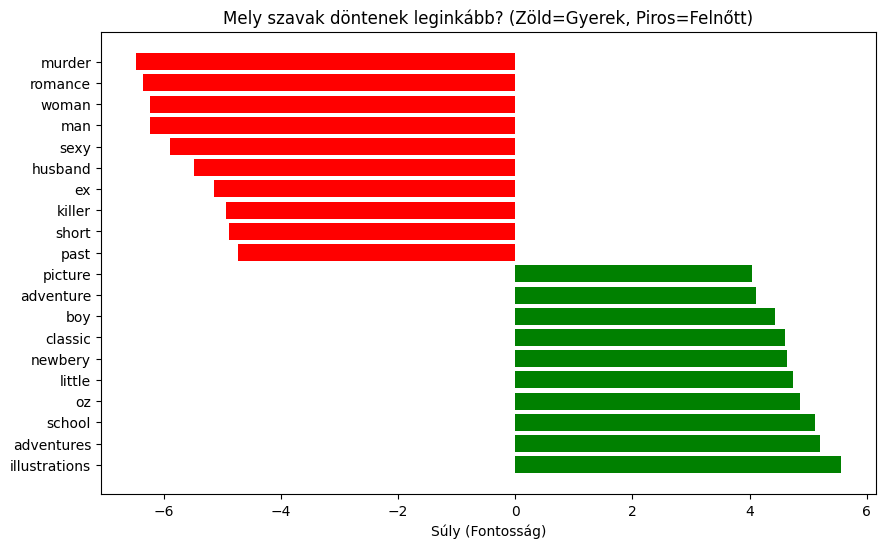

In [16]:
# ------ Feature Importance ------

# logisztikus regresszió esetén
ref_model = models["Logistic Regression"]

# szavakat a TF-IDF-ből
feature_names = tfidf.get_feature_names_out()

# oldalszám
feature_names = np.append(feature_names, "OLDALSZÁM (PAGES)")

# súlyok
coefs = ref_model.coef_[0]

df_imp = pd.DataFrame({'feature': feature_names, 'importance': coefs})
df_imp = df_imp.sort_values(by='importance', ascending=False)

print("------ A MODELL SZERINTI KULCSSZAVAK ------")
print("\nTOP 10 'GYEREK' JELLEMZŐ (Pozitív súlyok):")
print(df_imp.head(10))

print("\nTOP 10 'FELNŐTT' JELLEMZŐ (Negatív súlyok):")
print(df_imp.tail(10))

plt.figure(figsize=(10, 6))
top_bottom = pd.concat([df_imp.head(10), df_imp.tail(10)])
colors = ['green' if x > 0 else 'red' for x in top_bottom['importance']]
plt.barh(top_bottom['feature'], top_bottom['importance'], color=colors)
plt.title("Mely szavak döntenek leginkább? (Zöld=Gyerek, Piros=Felnőtt)")
plt.xlabel("Súly (Fontosság)")
plt.show()

Végső teszt futtatása a 'MLP Neural Net' modellel...


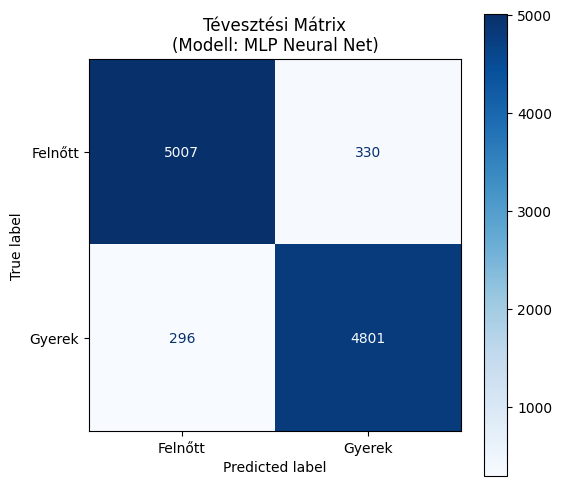

In [17]:
# ------ MODELL ÉRTÉKELÉSE A TESZT HALMAZON ------

print(f"Végső teszt futtatása a '{best_model_name}' modellel...")

# előrejelzés a TESZT halmazon
y_pred_test = best_model_obj.predict(X_test)

# valószínűségek a ROC görbéhez
if hasattr(best_model_obj, "predict_proba"):
    y_prob_test = best_model_obj.predict_proba(X_test)[:, 1]
else:
    y_prob_test = y_pred_test

# ------ KONFÚZIÓS MÁTRIX (tévedések) ------
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Felnőtt', 'Gyerek'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title(f'Tévesztési Mátrix\n(Modell: {best_model_name})')
plt.grid(False)
plt.show()

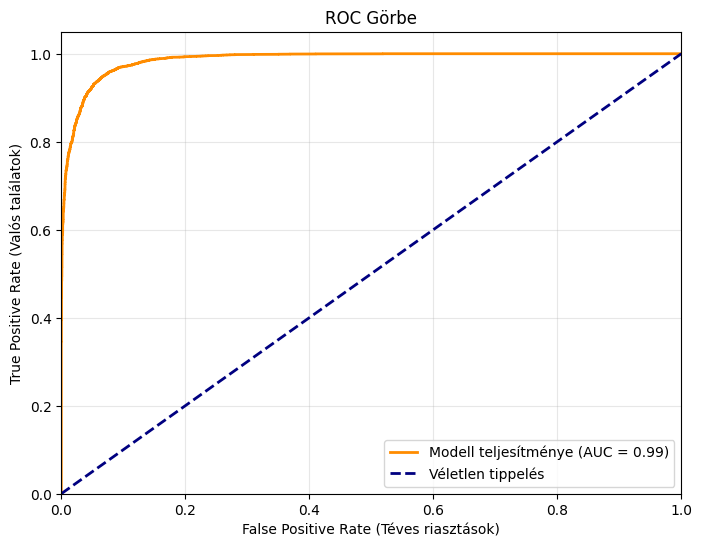

              precision    recall  f1-score   support

     Felnőtt       0.94      0.94      0.94      5337
      Gyerek       0.94      0.94      0.94      5097

    accuracy                           0.94     10434
   macro avg       0.94      0.94      0.94     10434
weighted avg       0.94      0.94      0.94     10434



In [18]:
# ------ ROC GÖRBE (teljesítmény görbe) ------
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modell teljesítménye (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Véletlen tippelés')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Téves riasztások)')
plt.ylabel('True Positive Rate (Valós találatok)')
plt.title('ROC Görbe')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(classification_report(y_test, y_pred_test, target_names=['Felnőtt', 'Gyerek']))

In [ ]:
# ------ GRADIO alkalmazás ------

def predict_book_category(description, num_pages):

    clean_desc = preprocess_text(description)
    if not clean_desc or len(clean_desc) < 5:
        return {"Hiba: Túl rövid vagy értelmezhetetlen szöveg": 1.0}

    # VEKTORIZÁLÁS (A betanított 'tfidf' objektummal)
    text_vector = tfidf.transform([clean_desc])

    # OLDALSZÁM SKÁLÁZÁS (A betanított 'scaler' objektummal)
    pages_scaled = scaler.transform([[num_pages]])

    # ÖSSZEFŰZÉS
    features = hstack([text_vector, pages_scaled])

    # PREDIKCIÓ
    probs = best_model_obj.predict_proba(features)[0]

    return {
        "Felnőtteknek szóló könyv 🔞": float(probs[0]),
        "Gyerekkönyv 🧸": float(probs[1])
    }

demo = gr.Interface(
    fn=predict_book_category,
    inputs=[
        gr.Textbox(lines=5, placeholder="Ide másold a könyv angol leírását...", label="Description"),
        gr.Number(value=250, label="Oldalak száma")
    ],
    outputs=gr.Label(num_top_classes=2, label="Az AI döntése"),
    title="Bináris 📚 osztályozó",
    description="A modell leírás és az oldalszám alapján dönti el, hogy egy könyv gyerekeknek vagy felnőtteknek szól-e.",
    examples=[
        ["The classic work on investing, filled with sound and safe principles that are as reliable as ever, now revised with an introduction and appendix by financial legend Warren Buffett—one of the author’s most famous students—and newly updated commentaries on each chapter from distinguished Wall Street Journal writer Jason Zweig.", 640],
        ["Winnie the Pooh has enchanted readers of all ages for nearly one hundred years with its relatable, heartwarming adventures that follow the famously friendly and lovable teddy bear. In this classic collection, Winnie navigates the Hundred Acre Wood with Christopher Robin, Eeyore, Piglet, Owl, and Rabbit, learning the true meaning of friendship and the value of accepting everyone exactly as they are.", 176],
        ["A detective investigates a mysterious murder in a small town where everyone has secrets.", 350]
    ],
    theme="soft",
    allow_flagging="never"
)

print("Az alkalmazás indítása...")
demo.launch(share=True, debug=True)

Az alkalmazás indítása...


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://588a7cc0b0557728ef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Összegzés és eredmények

A projekt célja egy olyan könyvkategorizáló modell létrehozása volt, amely képes megkülönböztetni a gyermek és a felnőttirodalmat.

A jelenlegi megoldás **93% feletti pontosságot** ér el, ami önmagában jó eredménynek számít. Fontos azonban hangsúlyozni, hogy a modell egy leegyszerűsített, kétosztályos feladatra készült, ami jelentősen megkönnyíti a döntési folyamatot.

### Korlátok

* **Nyelvi kötöttség:** A rendszer kizárólag **angol nyelvű** szövegeken alkalmazható, mivel a használt szótárak és nyelvi erőforrások erre a nyelvre épülnek.
* **Merev kategóriarendszer:** A modell csak két kategóriával dolgozik (gyermek vs. felnőtt), ezért az átmeneti műfajokat (pl. az ifjúsági / Young Adult könyveket) nem képes önállóan kezelni, hanem szükségszerűen az egyik csoportba sorolja őket.
* Jelenleg a döntések elsősorban kulcsszavak jelenlétén alapulnak, így a modell nem érti a szöveg mélyebb jelentését, kontextusát vagy az olyan nyelvi jelenségeket, mint az irónia.

### Fejlesztési lehetőségek

* **Kontextusalapú nyelvi modellek alkalmazása:** Az alkalmazott statisztikai megközelítés továbbfejleszthető modern nyelvi modellekkel (például **BERT**), amelyek képesek figyelembe venni a mondatok szerkezetét és a szövegkörnyezetet.
* **Képi információk bevonása:** A szöveges elemzést ki lehetne egészíteni a **könyvborítók vizuális feldolgozásával**, mivel a gyermekkönyvek grafikai világa gyakran jól elkülöníthető a felnőtteknek szánt kiadványokétól.